In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 
# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from keras.applications.vgg16 import preprocess_input 

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload
from src.dataLoader import dataLoader
from src.utils import image_utils, ismember

from src.preprocessing import imadjust,imagecrop,imagePaddingByShape


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
dataset = dataLoader("../dataset")

fileNameList = [str(imgIdx)+".jpg" for imgIdx in range(500,1001)]
imageFileList = dataset.LoadFileList(fileNameList=fileNameList)

In [44]:
# ori_dataset = []
# dataset = []
# img_w,img_h,img_ch = 224,224,3

# model = VGG16()
# model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

# for image_path in imageFileList:
#     # get RGB image
#     color_image = image_utils().get_image(image_path, image_scale=cv2.COLOR_BGR2RGB, is_gray=False)
#     ori_dataset.append(color_image)
#     padded_img = imagePaddingByShape(color_image,(img_w,img_h,img_ch), padding_mode="median")
#     # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
#     reshaped_img = img.reshape(1,img_w,img_h,img_ch)

#     dataset.append(padded_img)


# dataset = np.array(dataset)
# dataset.shape

ori_dataset = []

for image_path in imageFileList:
    # get RGB image
    color_image = image_utils().get_image(image_path, image_scale=cv2.COLOR_BGR2RGB, is_gray=False)
    ori_dataset.append(color_image)

In [22]:
# load the model first and pass as an argument
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [23]:
data = {}
for image_path in imageFileList:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(image_path,model)
        data[image_path] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        pass

In [24]:
# get a list of the file Locations
fileLocations = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
print(feat.shape)

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
print(feat.shape)


(501, 1, 4096)
(501, 4096)


Components before PCA: 4096
Components after PCA: 100


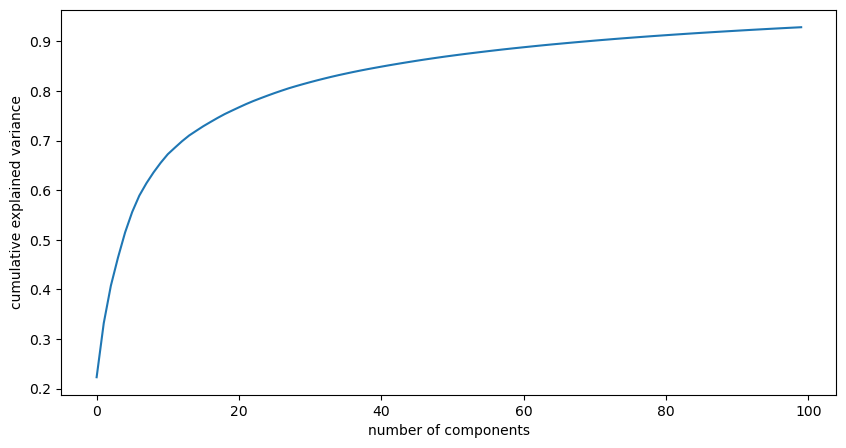

In [105]:
pca = PCA(n_components=100)
pca.fit(feat)
x = pca.transform(feat)

print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

# Clustering

In [106]:
No_feature = 8

# KMeans clustering

In [107]:
kmeans = KMeans(n_clusters=No_feature,init='random')
kmeans.fit(x)

KMeans(init='random')

In [108]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(fileLocations,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

cluster 0
82 elements


C:\Users\YUANMA\.conda\envs\CS5446\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


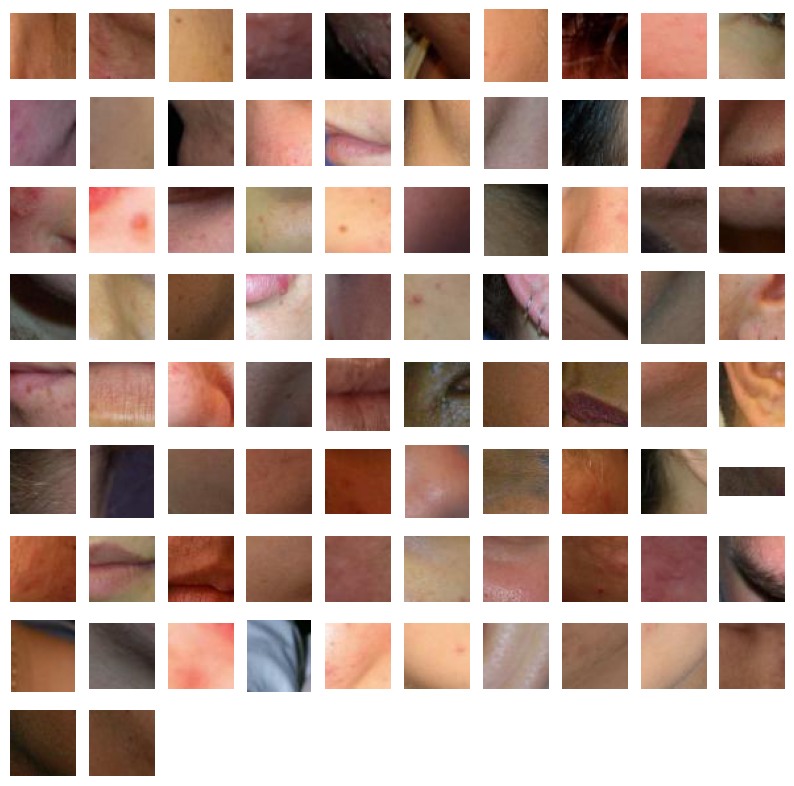

cluster 1
68 elements


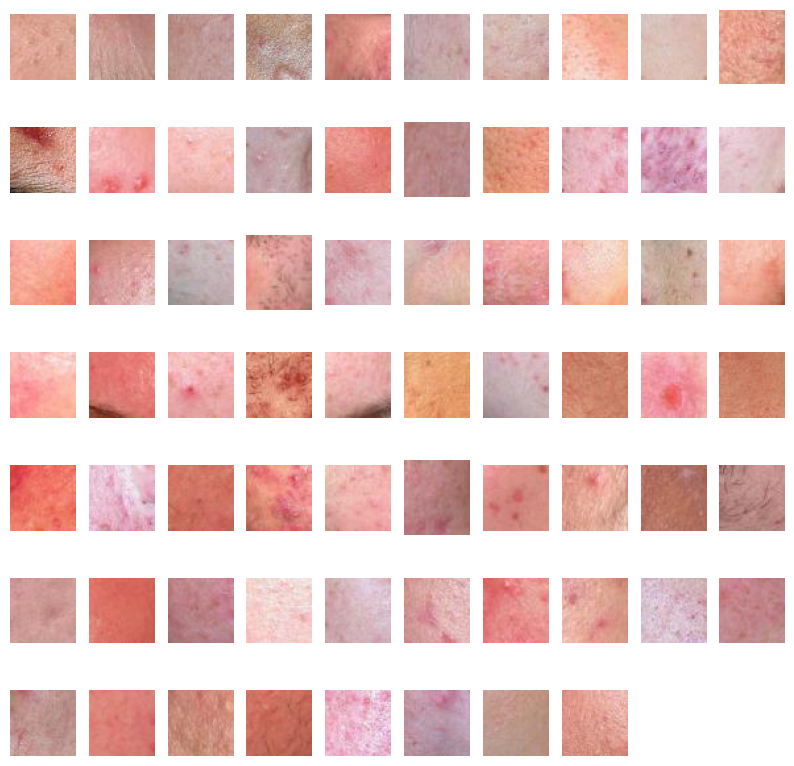

cluster 2
70 elements


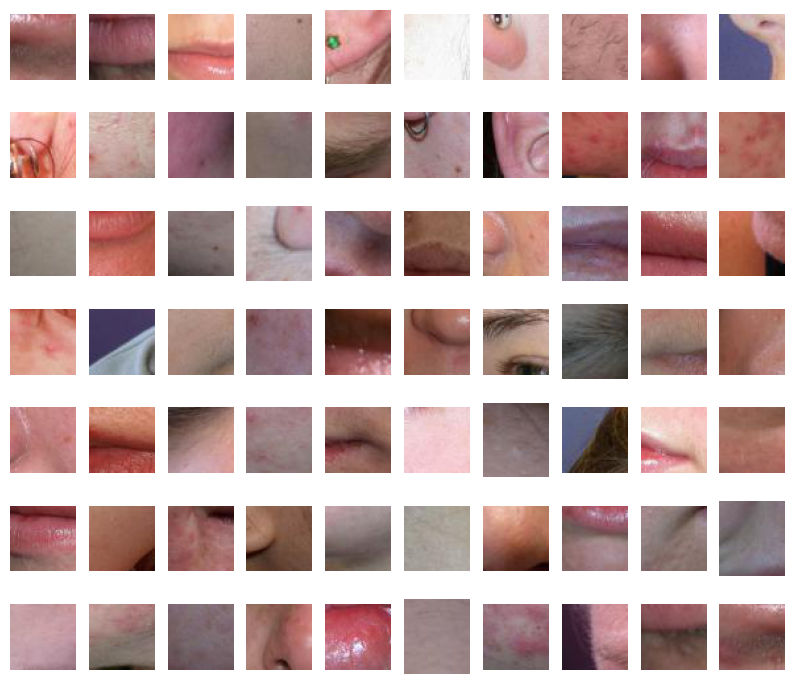

cluster 3
49 elements


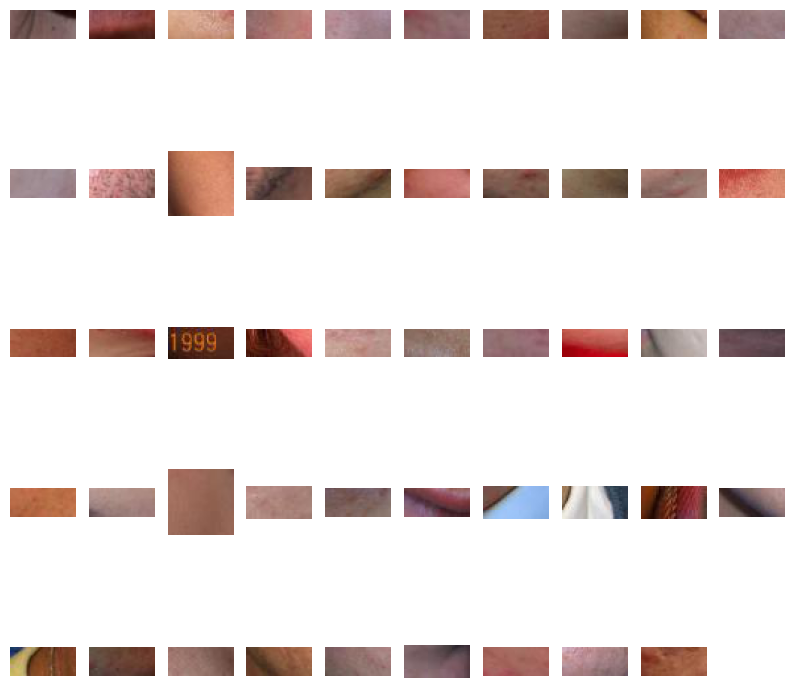

cluster 4
93 elements


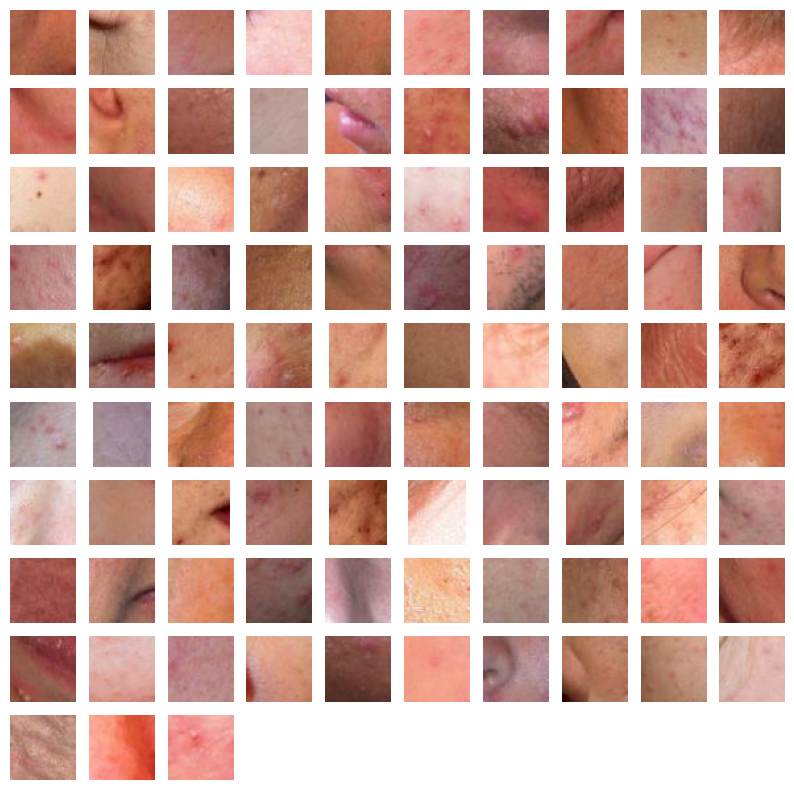

cluster 5
47 elements


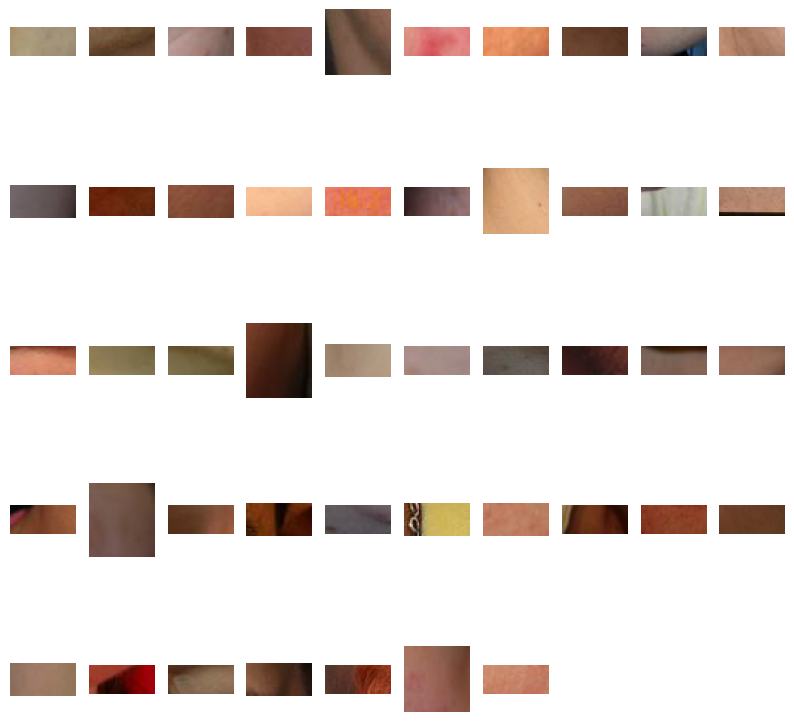

cluster 6
70 elements


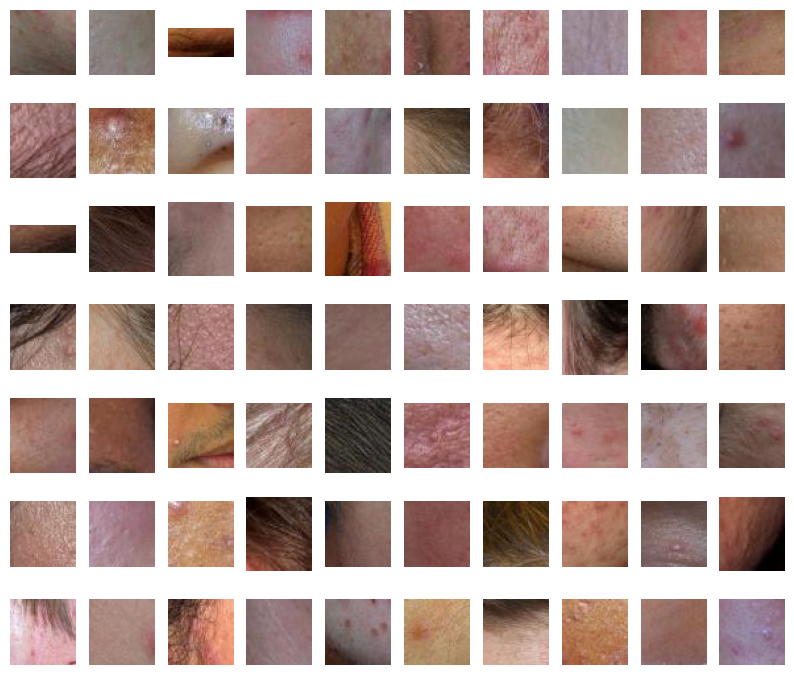

cluster 7
22 elements


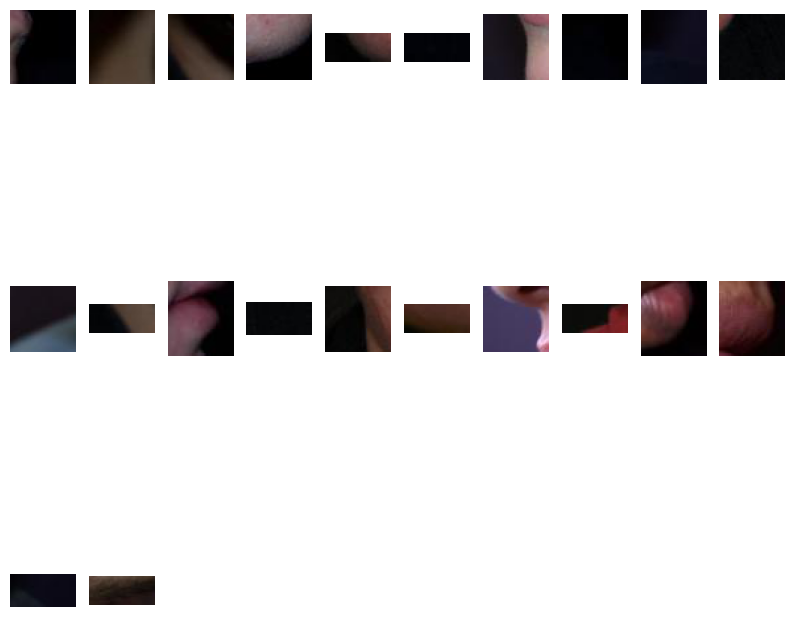

In [109]:
for i in range(0,No_feature):
    row = np.array(groups[i])  # row in Z for elements of cluster i
    num = row.shape[0]       #  number of elements for each cluster
    r = np.floor(num/10.)    # number of rows in the figure of the cluster 

    print("cluster "+str(i))
    print(str(num)+" elements")

    plt.figure(figsize=(10,10))
    plt.axis('off')
    for k in range(0, num):
        plt.subplot(r+1, 10, k+1)
        image = load_img(row[k])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

# Gaussian Mixture clustering

In [101]:
# from sklearn.mixture import GaussianMixture

# model = GaussianMixture(n_components=No_feature)
# # fit the model
# model.fit(x)
# # assign a cluster to each example
# yhat = model.predict(x)
# # retrieve unique clusters
# clusters = np.unique(yhat)

cluster 0
4 elements


C:\Users\YUANMA\.conda\envs\CS5446\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


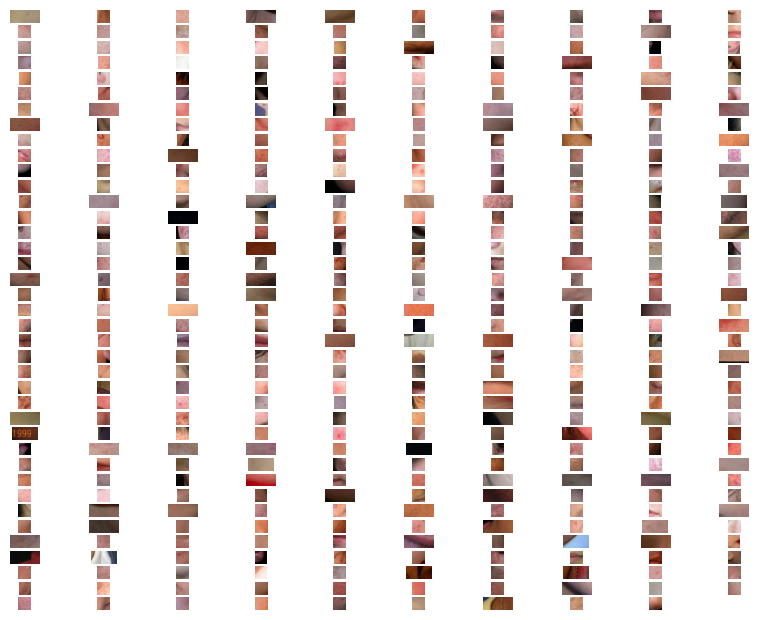

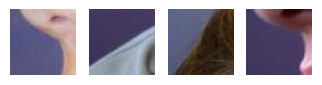

cluster 1
117 elements


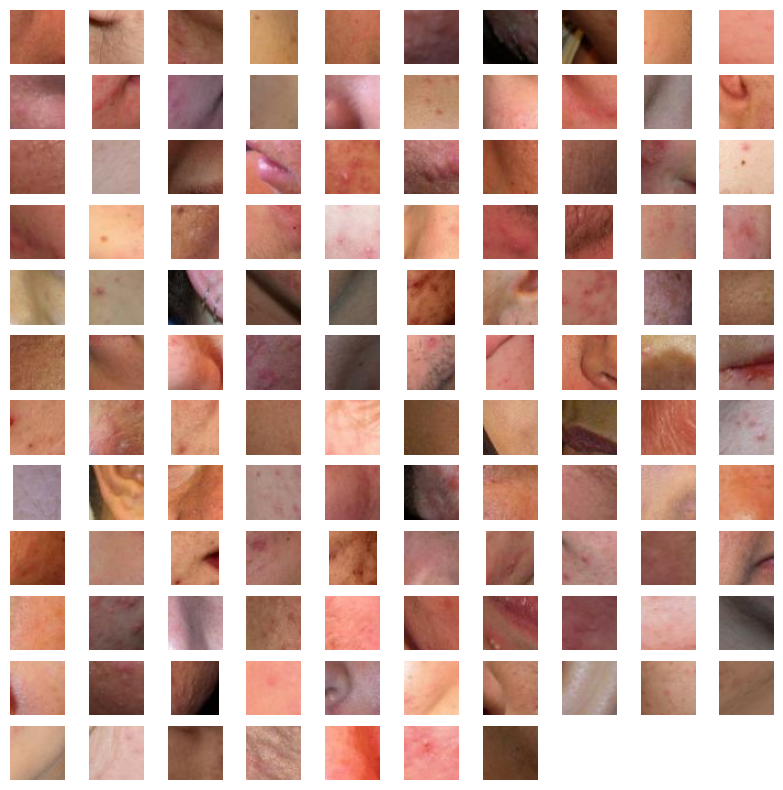

cluster 2
58 elements


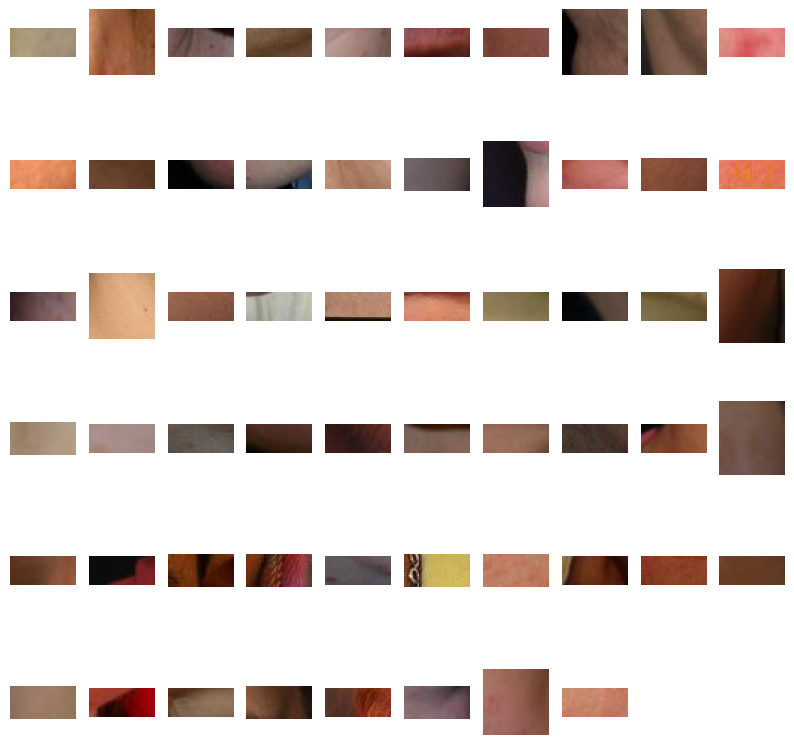

cluster 3
83 elements


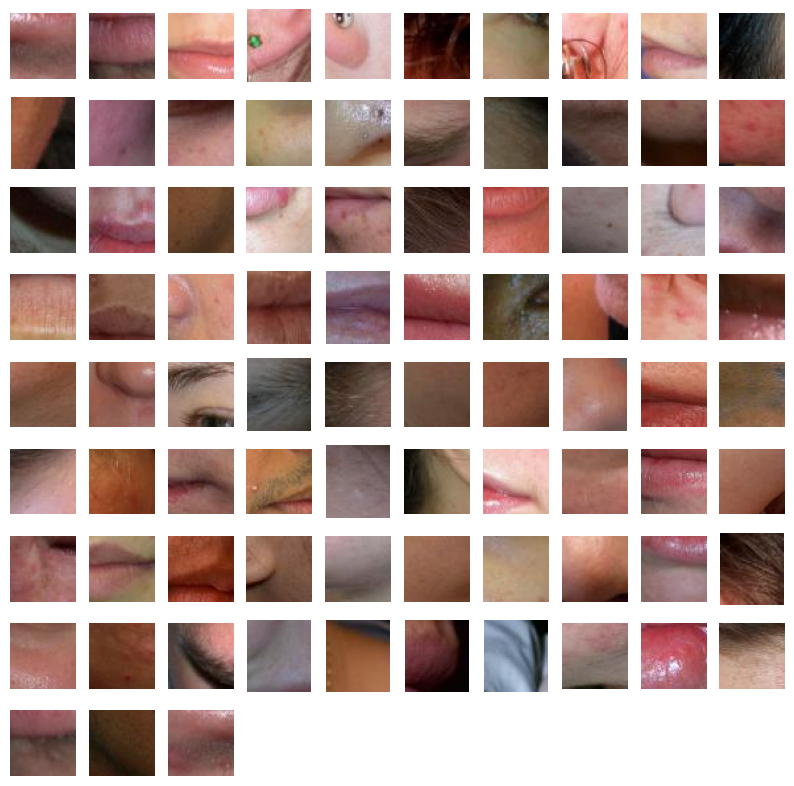

cluster 4
83 elements


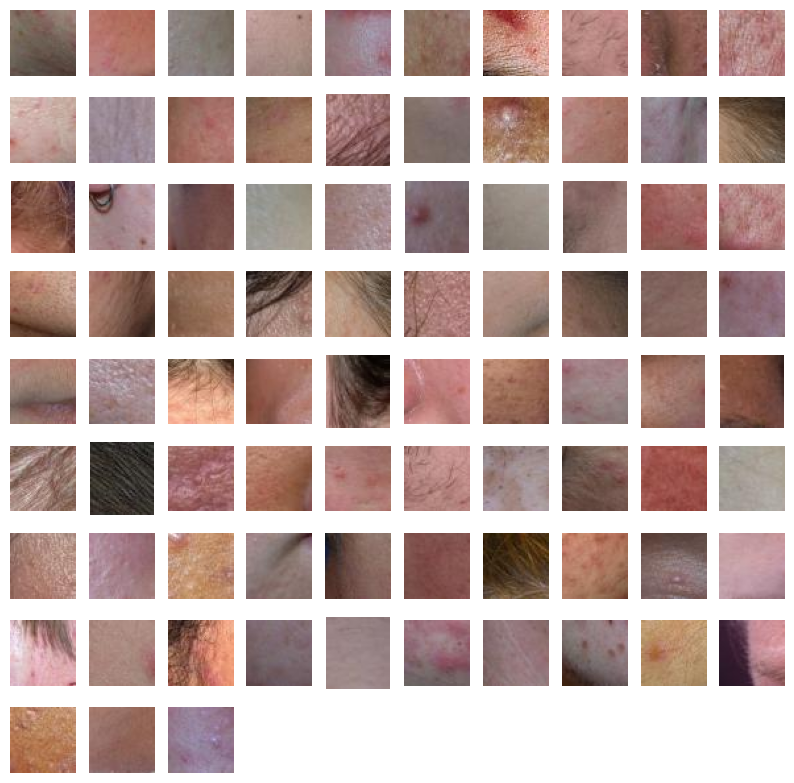

cluster 5
82 elements


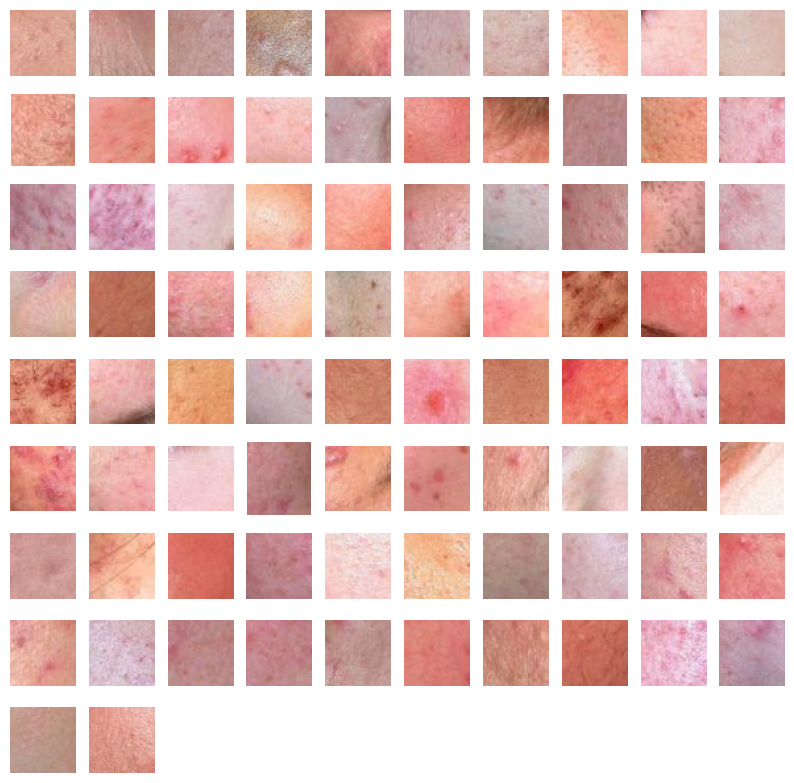

cluster 6
51 elements


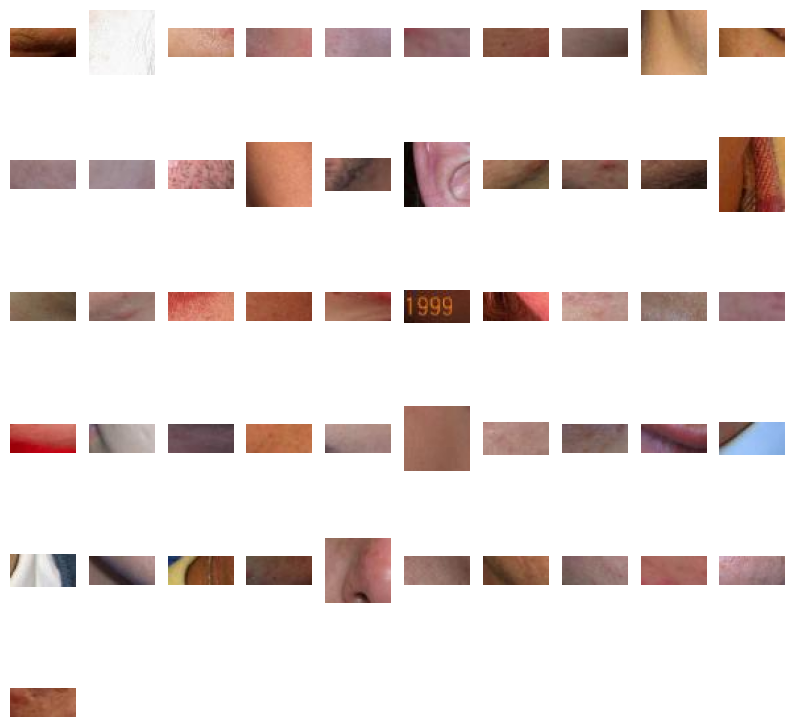

cluster 7
23 elements


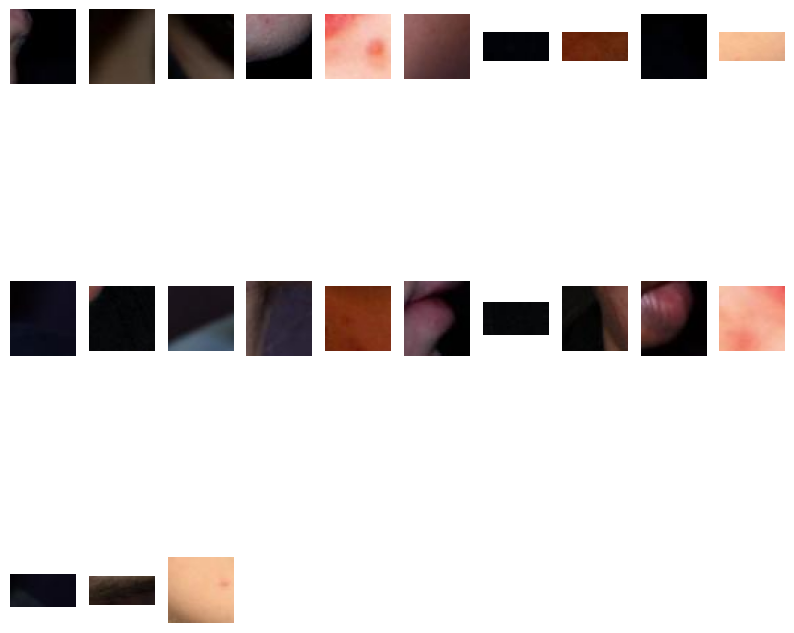

In [103]:
# for i in range(0,No_feature):

#     row = np.where(yhat==i)[0]  # row in Z for elements of cluster i
#     num = row.shape[0]       #  number of elements for each cluster
#     r = np.floor(num/10.)    # number of rows in the figure of the cluster 

#     print("cluster "+str(i))
#     print(str(num)+" elements")

#     plt.figure(figsize=(10,10))
#     for k in range(0, num):
#         plt.subplot(r+1, 10, k+1)
#         image = ori_dataset[row[k]]
#         # image = dataset[row[k]]
#         # image = image.reshape(50,50,3)
#         plt.imshow(image, cmap='gray')
#         plt.axis('off')
#     plt.show()

# data cleaning

In [112]:
# data cleaning
used_image=[]
clusters_used = [1,2,4,6]

for i in clusters_used:
    used_image+=groups[i]

len(used_image)

301

In [113]:
ori_dataset = []

for image_path in used_image:
    # get RGB image
    color_image = image_utils().get_image(image_path, image_scale=cv2.COLOR_BGR2RGB, is_gray=False)
    ori_dataset.append(color_image)

In [114]:
# load the model first and pass as an argument
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

data = {}
for image_path in used_image:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(image_path,model)
        data[image_path] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        pass

(301, 1, 4096)
(301, 4096)
Components before PCA: 4096
Components after PCA: 80


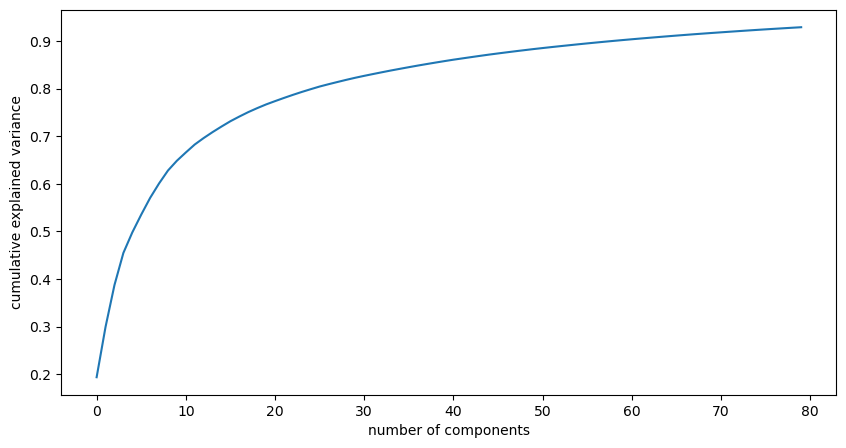

In [117]:
# get a list of the file Locations
fileLocations = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
print(feat.shape)

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
print(feat.shape)

pca = PCA(n_components=80)
pca.fit(feat)
x = pca.transform(feat)

print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

In [120]:
No_feature = 10

kmeans = KMeans(n_clusters=No_feature,init='random')
kmeans.fit(x)

# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(fileLocations,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

cluster 0
25 elements


C:\Users\YUANMA\.conda\envs\CS5446\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


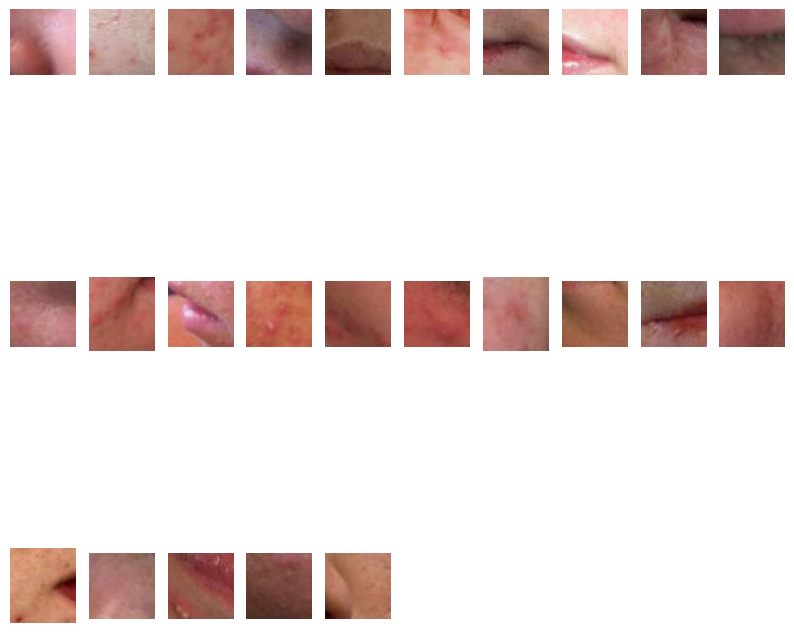

cluster 1
34 elements


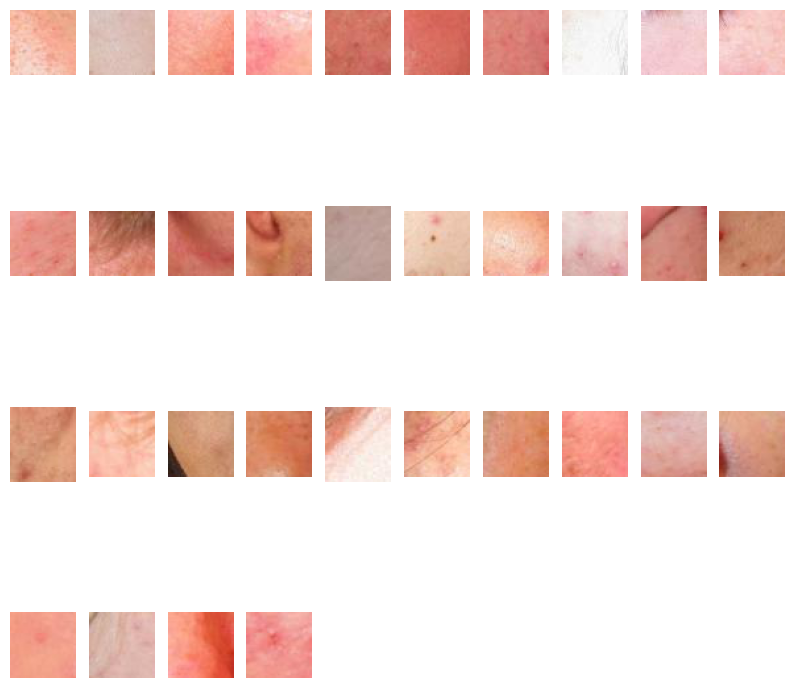

cluster 2
19 elements


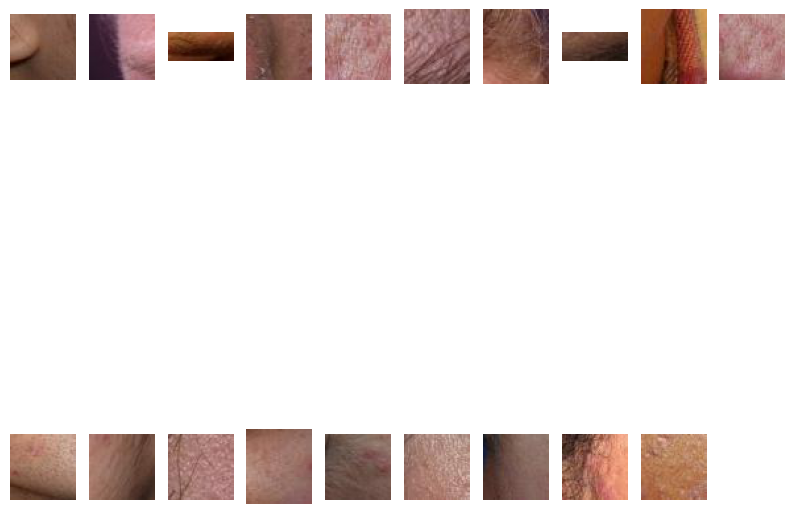

cluster 3
17 elements


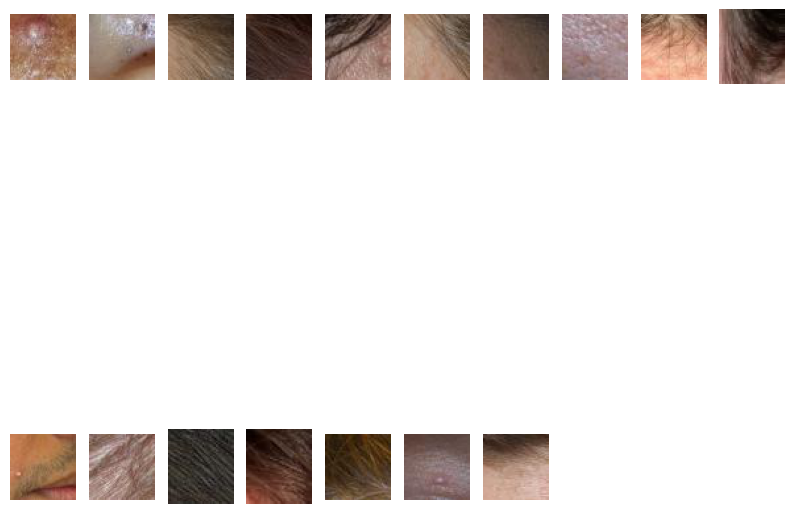

cluster 4
28 elements


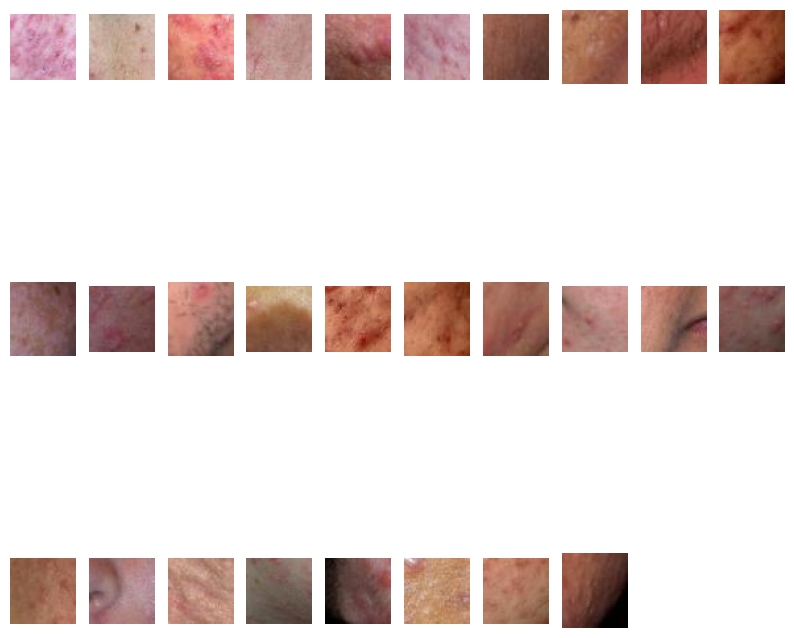

cluster 5
29 elements


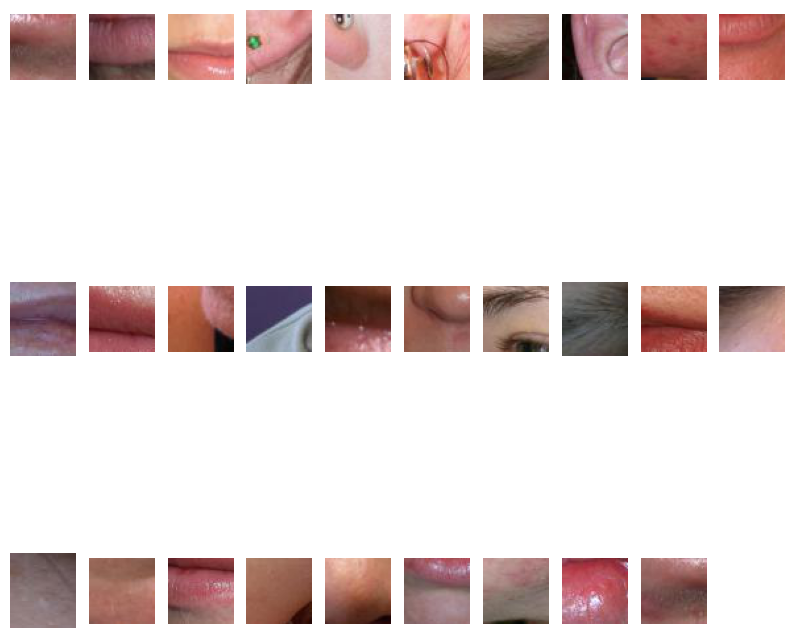

cluster 6
44 elements


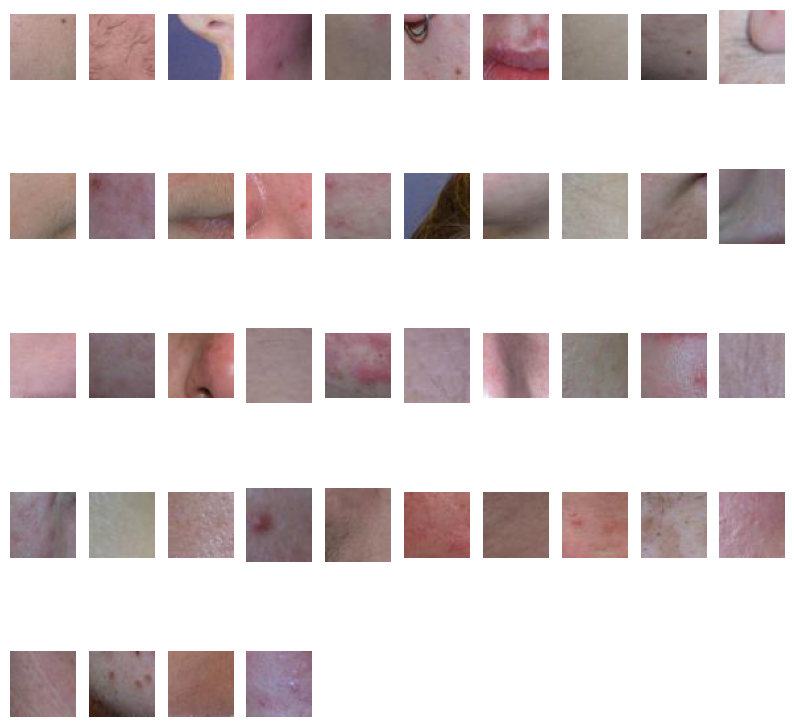

cluster 7
33 elements


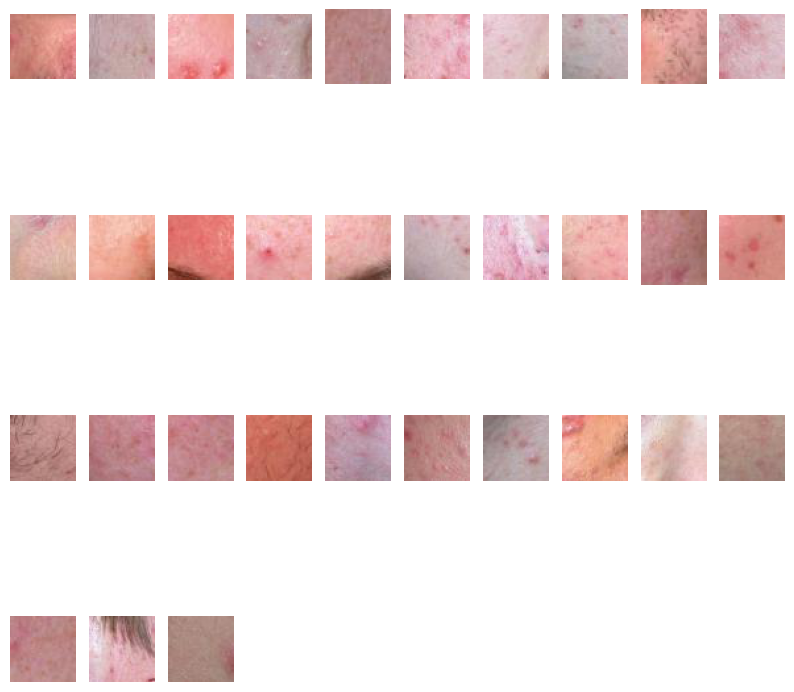

cluster 8
40 elements


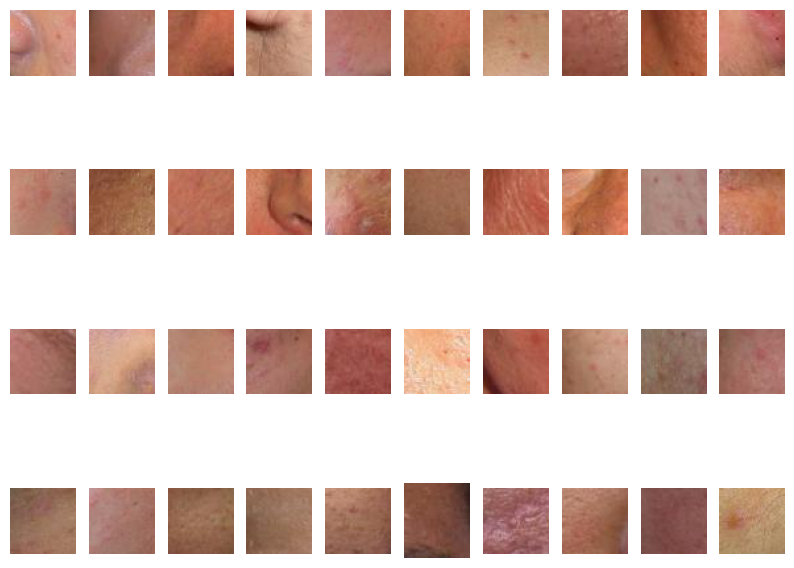

cluster 9
32 elements


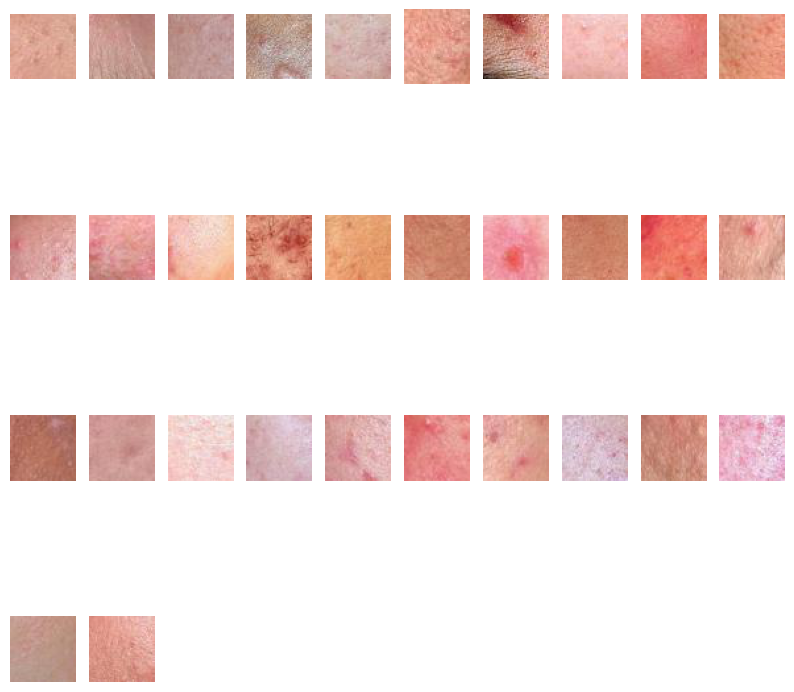

In [121]:

for i in range(0,No_feature):
    row = np.array(groups[i])  # row in Z for elements of cluster i
    num = row.shape[0]       #  number of elements for each cluster
    r = np.floor(num/10.)    # number of rows in the figure of the cluster 

    print("cluster "+str(i))
    print(str(num)+" elements")

    plt.figure(figsize=(10,10))
    plt.axis('off')
    for k in range(0, num):
        plt.subplot(r+1, 10, k+1)
        image = load_img(row[k])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

# ================================================================